In [1]:
from virusPropagationModel import *
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import timeit
import matplotlib.cm as cm 
 

In [2]:
modeledWorld1 = ModeledPopulatedWorld(1000,100, world_from_file=True, geofile_name='datafiles/Buildings_Gangelt_MA_3.csv')
print('Number of agents: '+ str(modeledWorld1.number_of_people))
print('distrution of initialized locations: ' + str(modeledWorld1.get_distribution_of_location_types()))

Number of agents: 1505
distrution of initialized locations: {'home': 496, 'work': 52, 'public_place': 11, 'school': 2, 'hospital': 1, 'cemetery': 1}


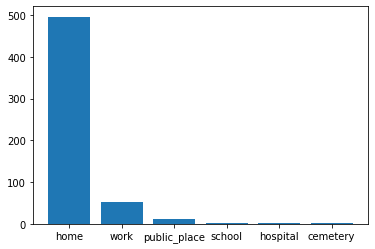

In [3]:
modeledWorld1.plot_distribution_of_location_types()

In [4]:
simulation1 = Simulation(modeledWorld1,200)

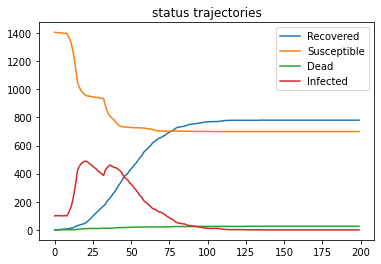

In [5]:
simulation1.plot_status_timecourse()





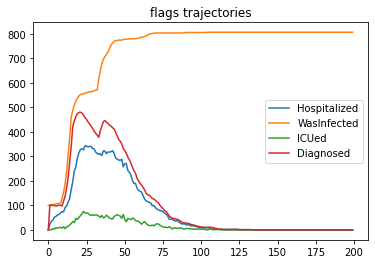

In [6]:
simulation1.plot_flags_timecourse()

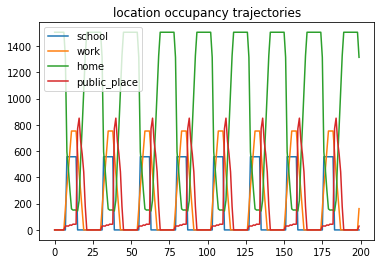

In [7]:
simulation1.plot_location_type_occupancy_timecourse()

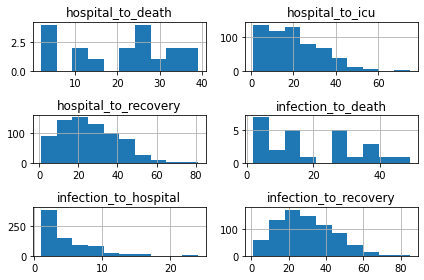

In [8]:
simulation1.plot_distributions_of_durations()

In [9]:
simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.

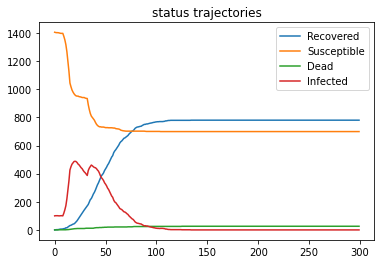

In [10]:
simulation2 = Simulation(simulation1,100) # Now Simulation class objects can be used for subsequent simulation (nested)
simulation2.plot_status_timecourse()

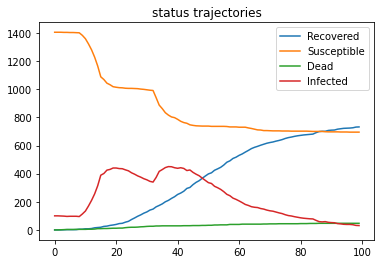

In [11]:
#now we can save and load worlds and simulations (exported to the folder saved_objects)
modeledWorld1.save('testingmyfirstworld')
loadedWorld1 = load_simulation_object('testingmyfirstworld')
simulationFromLoadedWorld1 = Simulation(loadedWorld1,100)
simulationFromLoadedWorld1.save('testingmyfirstsimulation')
loadedSimulation = load_simulation_object('testingmyfirstsimulation')
loadedSimulation.plot_status_timecourse()

In [12]:
loc_stat=simulation1.get_location_and_status()
print(loc_stat.head())

status  loc  time    D    I    R    S  x_coordinate  y_coordinate
0         0     0  0.0  0.0  0.0  2.0      5.988614     50.994357
1         0     1  0.0  0.0  0.0  2.0      5.988614     50.994357
2         0     2  0.0  0.0  0.0  2.0      5.988614     50.994357
3         0     3  0.0  0.0  0.0  2.0      5.988614     50.994357
4         0     4  0.0  0.0  0.0  2.0      5.988614     50.994357


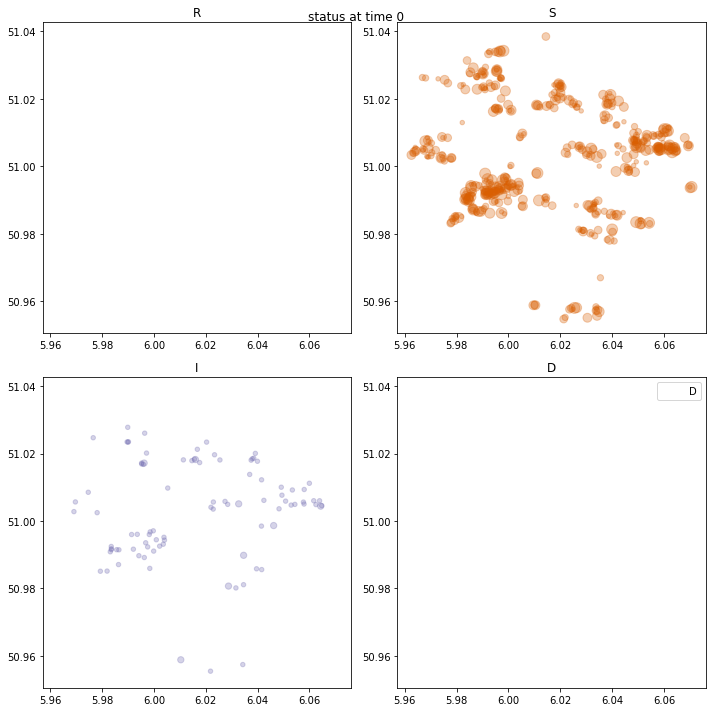

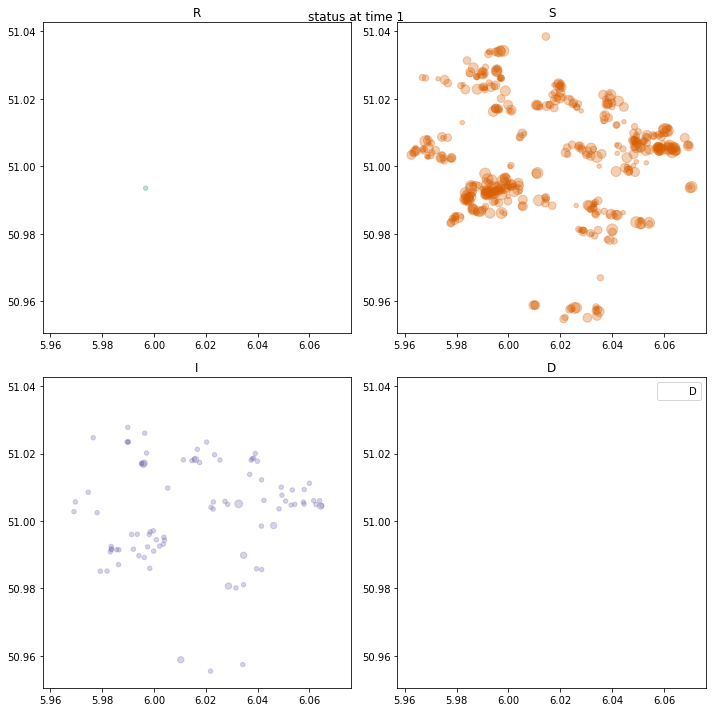

In [13]:
times = 2 
#times = max(loc_stat['time'])
for time in range(times):
    loc_stat_t = loc_stat[loc_stat['time']==time]
    cmap = cm.get_cmap('Dark2')

    plt.figure(figsize=(10,10))
    for k,stat in enumerate(['R','S','I','D']):
        plt.subplot(2,2,k+1)
        plt.title(stat)
        plt.scatter(loc_stat_t['x_coordinate'],loc_stat_t['y_coordinate'], s = 20*loc_stat_t[stat], alpha=0.3, label=stat, color=cmap(k))
    plt.suptitle('status at time '+str(time))
    plt.tight_layout()
    plt.legend()

    #plt.savefig('plots/loc_t_'+str(time)+'.png')

In [14]:
# removes files saved in the cells in this notebook
for file in glob.glob("*/testing*"):
    os.remove(file)